In [1]:
import pandas as pd 
import numpy as np
import os 
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt 

## Set input and output folders 

In [2]:
# analysis folder version  
analysis_version = '011'

In [3]:
out_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis',
                        analysis_version, 
                        '003_scatter_video_vs_outcomes_V2')

if not os.path.exists(out_path): 
    os.makedirs(out_path)

print(out_path)

C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis\011\003_scatter_video_vs_outcomes_V2


### Load Clean Data - no missing BW Data 
May be missing video data - see excel with counts 

In [4]:
# PWS 
zv_pws_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                    '000_merged_cleaned_data\zv_bw_merged_gait_vertical_PWS_1_clean.csv')
zv_pws_bw_clean_df = pd.read_csv(zv_pws_bw_clean_path, index_col = 0)

# FW 
zv_fw_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                   '000_merged_cleaned_data\zv_bw_merged_gait_vertical_FW_1_clean.csv') 
zv_fw_bw_clean_df = pd.read_csv(zv_fw_bw_clean_path, index_col = 0) 

In [5]:
# Home Videos 
hv_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                analysis_version, 
                                '000_merged_cleaned_data\hv_bw_merged_clean.csv') 

hv_bw_clean_df = pd.read_csv(hv_bw_clean_path, index_col = 0) 

In [6]:
hv_bw_clean_df.columns

Index(['video_id_date_name_pose_hv', 'id_date_pose_hv', 'task_pose_hv',
       'frames_per_second_pose_hv', 'total_video_duration_sec_pose_hv',
       'delta_pix_h_rel_median_pose_hv', 'walking_segmets_n_pose_hv',
       'walking_segments_duration_mean_pose_hv',
       'walking_segments_duration_median_pose_hv',
       'stride_time_num_strides_pose_hv',
       ...
       'pixels_notes', 'footfalls_in_frame_1', 'footfalls_in_frame_2',
       'footfalls_in_frame_3', 'footfalls_in_frame_4', 'avg_footfalls',
       'notes', 'multiple_people_YN', 'multiple_people_3',
       'assistive_device_YN'],
      dtype='object', length=134)

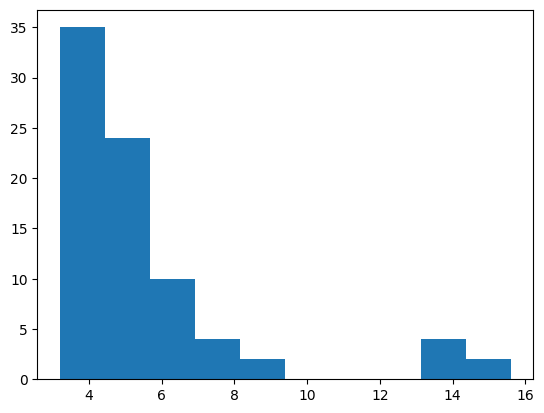

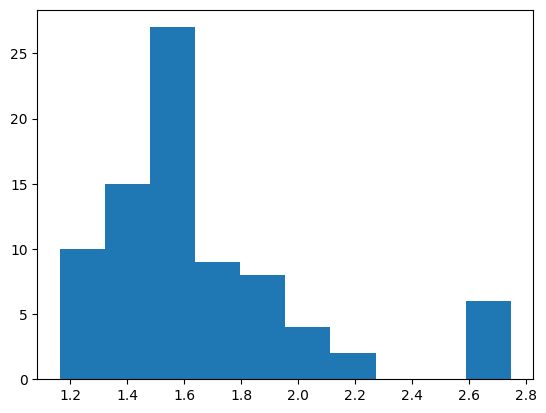

In [7]:
# home videos T25FW 
plt.hist(hv_bw_clean_df['clean_T25FW_Avg'])
plt.show()
plt.close()

# log transform T25FW 
hv_bw_clean_df['log_T25FW'] = np.log(hv_bw_clean_df['clean_T25FW_Avg'])
plt.hist(hv_bw_clean_df['log_T25FW'])
plt.show()
plt.close()

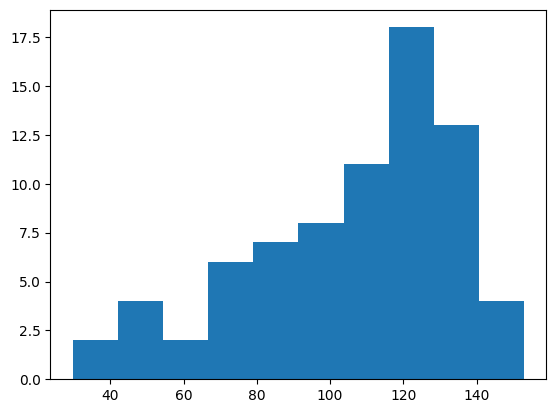

In [8]:
# pws at most recent visit 
plt.hist(hv_bw_clean_df['PWS_velocitycmsecmean'])
plt.show()
plt.close()

## Scatter plot, correlation, heatmat 
- scatter of each video metric vs: EDSS |  T25FW | Zeno PWS Velocity | Zeno FW Velocity
- heatmap
- .csv file of correlation matrix 

In [9]:
# correlation with clinical outcomes 
def video_vs_outcome_scatter(df, output_folder_path, subfolder_name, color_col): 
    
    out_plots_path = os.path.join(output_folder_path,  subfolder_name)
    
    if not os.path.exists(out_plots_path):
        os.makedirs(out_plots_path)

    if not os.path.exists(os.path.join(out_plots_path, 'edss scatter')):
        os.makedirs(os.path.join(out_plots_path, 'edss scatter'))

    if not os.path.exists(os.path.join(out_plots_path, 't25fw scatter')):
        os.makedirs(os.path.join(out_plots_path, 't25fw scatter'))

 #   if not os.path.exists(os.path.join(out_plots_path, 't25fw_log')):
     #   os.makedirs(os.path.join(out_plots_path, 't25fw_log'))

    if not os.path.exists(os.path.join(out_plots_path, 'PWS_velocity scatter')):
        os.makedirs(os.path.join(out_plots_path, 'PWS_velocity scatter'))

    if not os.path.exists(os.path.join(out_plots_path, 'FW_velocity scatter')):
        os.makedirs(os.path.join(out_plots_path, 'FW_velocity scatter'))
        

    # drop date time columns 
    if 'bw_hv_abs_date_diff' in df.columns:
        df = df.drop(columns=['bw_hv_abs_date_diff'])

    # drop unamed columns 
    unnamed_cols = df.columns[df.columns.str.contains('Unnamed:')].tolist()
    df = df.drop(columns=unnamed_cols)
 
    # Keep only numeric and ordinal columns and BW- ID 
    numeric_cols = df.select_dtypes(include=['number']).columns
    ordinal_cols = df.select_dtypes(include=['category']).columns
    num_ord_cols = numeric_cols.union(ordinal_cols)
    df_num = df[num_ord_cols.union(['bw_id'])]

    # Create an empty DataFrame to store the Spearman correlation coefficients
    n_cols = df_num.shape[1]

    corr_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    pvalue_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    n_videos_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    
    for col1 in df_num.columns:
        for col2 in df_num.columns:

            df_num_clean = df.dropna(subset=[col1, col2]) # drop rows if col1 and col2 are both nan

            # if string - don't run correlation 
            if  (df_num_clean[col1].dtype == 'object') or (df_num_clean[col2].dtype == 'object'):  
                corr = np.nan
                p_value = np.nan 
                
            # unless all values the same in one column, run spearman correlation
            elif df_num_clean[col1].nunique() <= 1 or df_num_clean[col2].nunique() <= 1: 
                corr = np.nan
                p_value = np.nan 

            else: 
                corr, p_value = stats.spearmanr(df_num_clean[col1], df_num_clean[col2])

            # save results in matrix 
            corr_matrix.loc[col1, col2] = round(corr, 2)
            pvalue_matrix.loc[col1, col2] = round(p_value, 3)
            n_videos_matrix.loc[col1, col2] = len(df_num_clean) # number of rows with data for both columns 

            # if home video - include BW-ID to plot 
            cols_to_plot = ['clean_EDSS', 
                            'clean_T25FW_Avg', 
                            'PWS_velocitycmsecmean', 
                            'FW_velocitycmsecmean']
            
            if ('Home' in subfolder_name) and (col1 in cols_to_plot): 
                for index, row in df_num_clean.iterrows(): 
                   # print(row) 
                    plt.annotate(row['bw_id'], 
                                 (row[col2], 
                                  row[col1]), 
                                 fontsize = 8
                                )

            # scatterplot of EDSS, T25FW, and mat velocity 
            if col1 == 'clean_EDSS':
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 6)
                plt.tight_layout()
                plt.savefig(os.path.join(out_plots_path, 'edss scatter', col2 + '.png'))
                plt.close()

            if col1 == 'clean_T25FW_Avg':
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 6)
                plt.tight_layout()
                plt.savefig(os.path.join(out_plots_path, 't25fw scatter', col2 + '.png'))
                plt.close()

            if col1 == 'PWS_velocitycmsecmean': 
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col)
                plt.title(subfolder_name)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 6)
                plt.tight_layout()
                plt.savefig(os.path.join(out_plots_path, 'PWS_velocity scatter', col2 + '.png'))
                plt.close()

            if col1 == 'FW_velocitycmsecmean': 
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 6)
                plt.tight_layout()
                plt.savefig(os.path.join(out_plots_path, 'FW_velocity scatter', col2 + '.png'))
                plt.close()

            
                   
    # save correlation matrix - full 
    corr_matrix.to_csv(os.path.join(out_plots_path, subfolder_name + '_corr_matrix.csv'))
    pvalue_matrix.to_csv(os.path.join(out_plots_path, subfolder_name + '_pvalue_matrix.csv'))
    n_videos_matrix.to_csv(os.path.join(out_plots_path, subfolder_name + '_n_pairs_matrix.csv'))

                
    # Keep specific values from corr_matrix and p-val matrix for heat map 
    outcomes_to_plot = ['clean_EDSS', 
                        'clean_T25FW_Avg',
                 #        'log_T25FW',
                         'PWS_velocitycmsecmean',
                         'FW_velocitycmsecmean']

    metrics_to_plot = ['delta_pix_h_rel_median_pose',
                       'stride_time_median_sec_pose',
                       'mean_cadence_step_per_min_pose',
                       'stride_width_median_cm_pose',
                     #  'stance_time_per_mean_pose',
                     #  'singlesupport_per_mean_pose', 
                     #  'tot_dsupport_per_mean_pose'
                       ]

    metrics_joined = '|'.join(metrics_to_plot)

    corr_matrix_filt = corr_matrix.loc[corr_matrix.index.isin(outcomes_to_plot), corr_matrix.columns.str.contains(metrics_joined)]

    # if home videos df, clean column and index labels for plotting 
    # in person video is zv 
    if 'delta_pix_h_rel_median_pose_hv' in corr_matrix_filt.columns:
        corr_matrix_filt = corr_matrix_filt.rename(columns = {'delta_pix_h_rel_median_pose_hv' : 'Change in Pixel Height', 
                                                              'stride_time_median_sec_pose_hv' : 'Stride Time', 
                                                              'mean_cadence_step_per_min_pose_hv' : 'Cadence', 
                                                              'stride_width_median_cm_pose_hv' : 'Stride Width', 
                                                            #  'tot_dsupport_per_mean_pose_hv' : 'Double Support %',
                                                            #  'singlesupport_per_mean_pose_hv' : 'Single Support %',
                                                              'PWS_velocitycmsecmean' : 'PWS Velocity (cm/second)', 
                                                              'FW_velocitycmsecmean' : 'FW Velocity (cm/second)', 
                                                               'clean_T25FW_Avg' : 'T25FW (seconds)', 
                                                              'clean_EDSS' : 'EDSS'}, 
                                                  index = {'delta_pix_h_rel_median_pose_hv' : 'Change in Pixel Height', 
                                                              'stride_time_median_sec_pose_hv' : 'Stride Time', 
                                                              'mean_cadence_step_per_min_pose_hv' : 'Cadence', 
                                                              'stride_width_median_cm_pose_hv' : 'Stride Width', 
                                                             # 'tot_dsupport_per_mean_pose_hv' : 'Double Support %', 
                                                             # 'singlesupport_per_mean_pose_hv' : 'Single Support %',
                                                               'PWS_velocitycmsecmean' : 'PWS Velocity (cm/second)', 
                                                               'FW_velocitycmsecmean' : 'FW Velocity (cm/second)', 
                                                               'clean_T25FW_Avg' : 'T25FW (seconds)', 
                                                               'clean_EDSS' : 'EDSS'}) 

    #  Plot and save the heatmap 
    plt.close() 
    plt.figure(figsize=(4, 2))
    sns.heatmap(corr_matrix_filt, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"fontsize": 7}, cbar_kws={"shrink": 0.8})
    plt.title(f"Spearman Correlation Heatmap: {subfolder_name}", fontsize = 9, fontweight = 'bold')
    plt.xticks(fontsize=7, fontstyle = 'italic')
    plt.yticks(fontsize=7, fontstyle = 'italic')
    plt.savefig(os.path.join(out_plots_path, subfolder_name + '_heatmap.png'), bbox_inches = 'tight')
    plt.show()
    plt.close()



# Plot each numeric columns vs EDSS, T25FW, PWS and FW velocity 
Color by one column 

## home select specific cols and rows 
only use subset of columns to run analysis faster 

In [10]:
hv_bw_clean_df.columns

Index(['video_id_date_name_pose_hv', 'id_date_pose_hv', 'task_pose_hv',
       'frames_per_second_pose_hv', 'total_video_duration_sec_pose_hv',
       'delta_pix_h_rel_median_pose_hv', 'walking_segmets_n_pose_hv',
       'walking_segments_duration_mean_pose_hv',
       'walking_segments_duration_median_pose_hv',
       'stride_time_num_strides_pose_hv',
       ...
       'footfalls_in_frame_1', 'footfalls_in_frame_2', 'footfalls_in_frame_3',
       'footfalls_in_frame_4', 'avg_footfalls', 'notes', 'multiple_people_YN',
       'multiple_people_3', 'assistive_device_YN', 'log_T25FW'],
      dtype='object', length=135)

In [11]:
# video metrics to average 
hv_colnames = ['delta_pix_h_rel_median_pose_hv',
               'stride_time_median_sec_pose_hv', 
               'mean_cadence_step_per_min_pose_hv',
               'stride_width_median_cm_pose_hv',
               'singlesupport_per_mean_pose_hv',
               'tot_dsupport_per_mean_pose_hv']

bw_colnames = ['PWS_velocitycmsecmean', 'FW_velocitycmsecmean', 'clean_T25FW_Avg', 'clean_EDSS', 
              #  'log_T25FW', 
              'PWS_cadencestepsminmean', 'PWS_singlesupportmean', 'PWS_stridetimesecmean', 
              'PWS_stridewidthcmmean',	'PWS_totaldsupportmean']


hv_bw_colnames = hv_colnames + bw_colnames + ['bw_id', 'task_pose_hv', 'video_id_date_name_pose_hv', 'id_date_pose_hv', 'bw_hv_date_diff_days',
                                             'avg_footfalls', 'stride_time_num_strides_pose_hv', 'mp_spinning', 'home_or_clinic', 'assistive_device_YN', 'lighting', 'light_source',
                                             'hv_edss_date_diff', 'hv_t25fw_date_diff']
hv_bw_colnames

['delta_pix_h_rel_median_pose_hv',
 'stride_time_median_sec_pose_hv',
 'mean_cadence_step_per_min_pose_hv',
 'stride_width_median_cm_pose_hv',
 'singlesupport_per_mean_pose_hv',
 'tot_dsupport_per_mean_pose_hv',
 'PWS_velocitycmsecmean',
 'FW_velocitycmsecmean',
 'clean_T25FW_Avg',
 'clean_EDSS',
 'PWS_cadencestepsminmean',
 'PWS_singlesupportmean',
 'PWS_stridetimesecmean',
 'PWS_stridewidthcmmean',
 'PWS_totaldsupportmean',
 'bw_id',
 'task_pose_hv',
 'video_id_date_name_pose_hv',
 'id_date_pose_hv',
 'bw_hv_date_diff_days',
 'avg_footfalls',
 'stride_time_num_strides_pose_hv',
 'mp_spinning',
 'home_or_clinic',
 'assistive_device_YN',
 'lighting',
 'light_source',
 'hv_edss_date_diff',
 'hv_t25fw_date_diff']

In [12]:
hv_bw_clean_df_simple = hv_bw_clean_df[hv_bw_colnames]
hv_bw_clean_df_simple.head()    

,delta_pix_h_rel_median_pose_hv,stride_time_median_sec_pose_hv,mean_cadence_step_per_min_pose_hv,stride_width_median_cm_pose_hv,singlesupport_per_mean_pose_hv,tot_dsupport_per_mean_pose_hv,PWS_velocitycmsecmean,FW_velocitycmsecmean,clean_T25FW_Avg,clean_EDSS,...,bw_hv_date_diff_days,avg_footfalls,stride_time_num_strides_pose_hv,mp_spinning,home_or_clinic,assistive_device_YN,lighting,light_source,hv_edss_date_diff,hv_t25fw_date_diff
0,0.06,1.367,87.805,10.670,NaN,NaN,136.683,123.480,3.6,3.0,...,0,3.25,1.0,yes,home,N,well_lit,windows_visible,0,0
1,0.40,1.050,114.545,13.704,NaN,NaN,136.683,123.480,3.6,3.0,...,0,3.00,2.0,yes,home,N,well_lit,windows_visible,0,0
2,0.40,1.033,115.303,11.127,38.57,23.13,115.829,190.263,3.4,3.5,...,9,7.75,20.0,no,home,N,well_lit,outdoors,25,9
3,0.40,1.067,108.000,11.582,35.65,27.34,115.829,190.263,3.4,3.5,...,9,7.75,30.0,no,home,N,well_lit,outdoors,25,9
4,0.32,1.000,116.273,9.131,37.55,24.72,139.984,204.592,4.4,3.0,...,0,8.00,13.0,no,clinic,N,well_lit,both_visible,0,0


## Home all Videos 

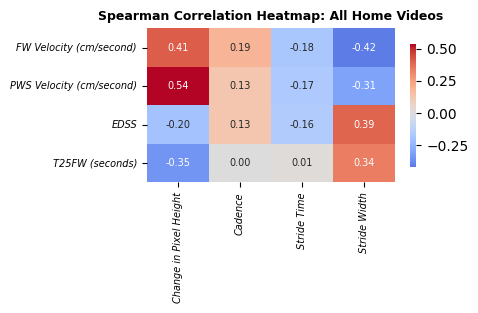

In [13]:
video_vs_outcome_scatter(df = hv_bw_clean_df_simple, 
                         output_folder_path = out_path, 
                         subfolder_name = 'All Home Videos',
                         color_col = 'bw_id')

## Home videos only right turning 

In [14]:
# clean - right_2 --> right and same for left 
hv_bw_clean_df_simple['task_pose_hv'] = hv_bw_clean_df_simple['task_pose_hv'].replace('gait_vertical_left_2', 'gait_vertical_left')
hv_bw_clean_df_simple['task_pose_hv'] = hv_bw_clean_df_simple['task_pose_hv'].replace('gait_vertical_right_2', 'gait_vertical_right')
hv_bw_clean_df_simple['task_pose_hv'].value_counts()

C:\Users\mmccu\AppData\Local\Temp\ipykernel_24968\3262720546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hv_bw_clean_df_simple['task_pose_hv'] = hv_bw_clean_df_simple['task_pose_hv'].replace('gait_vertical_left_2', 'gait_vertical_left')
C:\Users\mmccu\AppData\Local\Temp\ipykernel_24968\3262720546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hv_bw_clean_df_simple['task_pose_hv'] = hv_bw_clean_df_simple['task_pose_hv'].replace('gait_vertical_right_2', 'gait_vertical_right')


task_pose_hv
gait_vertical_right    41
gait_vertical_left     40
Name: count, dtype: int64

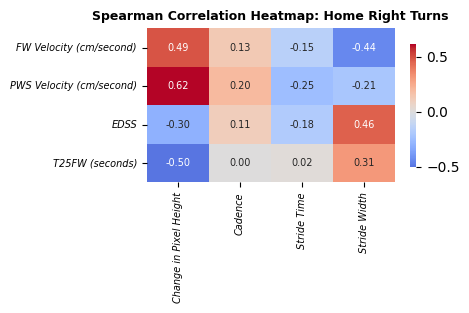

In [15]:
# Home Right 
hv_bw_clean_df_right = hv_bw_clean_df_simple.loc[hv_bw_clean_df_simple['task_pose_hv'] == 'gait_vertical_right']
hv_bw_clean_df_right['task_pose_hv'].value_counts()

video_vs_outcome_scatter(df = hv_bw_clean_df_right, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns', 
                         color_col = 'PWS_velocitycmsecmean')

### Right - group by date diff between video and T25FW 

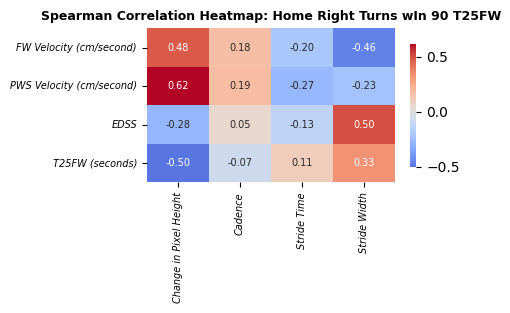

In [16]:
# within 90 days 
hv_bw_clean_df_wIn90T25FW_R = hv_bw_clean_df_right.loc[hv_bw_clean_df_right['hv_t25fw_date_diff'] <= 90] 

video_vs_outcome_scatter(df = hv_bw_clean_df_wIn90T25FW_R, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns wIn 90 T25FW', 
                         color_col = 'bw_id')

KeyboardInterrupt: 

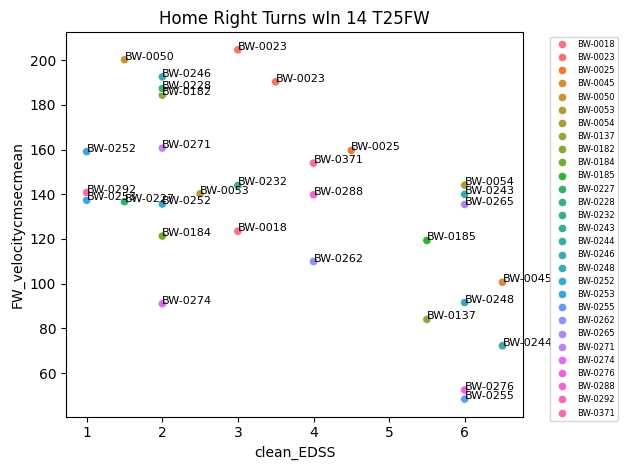

In [17]:
# within 14 days  
hv_bw_clean_df_wIn14T25FW_R = hv_bw_clean_df_right.loc[hv_bw_clean_df_right['hv_t25fw_date_diff'] <= 14] 

video_vs_outcome_scatter(df = hv_bw_clean_df_wIn14T25FW_R, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns wIn 14 T25FW', 
                         color_col = 'bw_id')

### Right: AD 

In [ ]:
# No assistive device 
hv_bw_clean_df_noAD_R = hv_bw_clean_df_right.loc[hv_bw_clean_df_right['assistive_device_YN'] == 'N'] 
print(hv_bw_clean_df_noAD_R['assistive_device_YN'].value_counts()) 

video_vs_outcome_scatter(df = hv_bw_clean_df_noAD_R, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns No AD', 
                         color_col = 'bw_id')

### Right Number of footfalls 

In [ ]:
# more than 5 footfalls average per pass 
hv_bw_clean_df_5Foot_R = hv_bw_clean_df_right.loc[hv_bw_clean_df_right['avg_footfalls'] >= 5] 
print(hv_bw_clean_df_5Foot_R['avg_footfalls'].value_counts()) 

video_vs_outcome_scatter(df = hv_bw_clean_df_5Foot_R, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns 5 Footfalls', 
                         color_col = 'bw_id')

### Right spinning 
From manual review - is MP plots spinning? 

In [ ]:
# not spinning videos - from manual review 
hv_bw_clean_df_noSpin_R = hv_bw_clean_df_right.loc[hv_bw_clean_df_right['mp_spinning'] == 'no'] 
print(hv_bw_clean_df_noSpin_R['mp_spinning'].value_counts()) 

video_vs_outcome_scatter(df = hv_bw_clean_df_noSpin_R, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns No Spin', 
                         color_col = 'bw_id')

## Home videos only left turning  

In [ ]:
# Home Left 
hv_bw_clean_df_left = hv_bw_clean_df_simple.loc[hv_bw_clean_df_simple['task_pose_hv'] == 'gait_vertical_left']
hv_bw_clean_df_left['task_pose_hv'].value_counts()

video_vs_outcome_scatter(df = hv_bw_clean_df_left, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns', 
                         color_col = 'PWS_velocitycmsecmean')

### Left group by date between video and T25FW 

In [ ]:
# within 90 days 
hv_bw_clean_df_wIn90T25FW_L = hv_bw_clean_df_left.loc[hv_bw_clean_df_left['hv_t25fw_date_diff'] <= 90] 

video_vs_outcome_scatter(df = hv_bw_clean_df_wIn90T25FW_L, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns wIn 90 T25FW', 
                         color_col = 'bw_id')

In [ ]:
# within 14 days 
hv_bw_clean_df_wIn14T25FW_L = hv_bw_clean_df_left.loc[hv_bw_clean_df_left['hv_t25fw_date_diff'] <= 14] 

video_vs_outcome_scatter(df = hv_bw_clean_df_wIn14T25FW_L, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns wIn 14 T25FW', 
                         color_col = 'bw_id')

### Left AD 

In [ ]:
# No assistive device 
hv_bw_clean_df_noAD_L = hv_bw_clean_df_left.loc[hv_bw_clean_df_left['assistive_device_YN'] == 'N'] 
print(hv_bw_clean_df_noAD_L['assistive_device_YN'].value_counts()) 

video_vs_outcome_scatter(df = hv_bw_clean_df_noAD_L, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns No AD', 
                         color_col = 'bw_id')

### Left Number of footfalls 

In [ ]:
# more than 5 footfalls average per pass 
hv_bw_clean_df_5Foot_L = hv_bw_clean_df_left.loc[hv_bw_clean_df_left['avg_footfalls'] >= 5] 

video_vs_outcome_scatter(df = hv_bw_clean_df_5Foot_L, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns 5 Footfalls', 
                         color_col = 'bw_id')

### Left MP spinning ? 

In [ ]:
# not spinning videos - from manual review 
hv_bw_clean_df_noSpin_L = hv_bw_clean_df_left.loc[hv_bw_clean_df_left['mp_spinning'] == 'no'] 
print(hv_bw_clean_df_noSpin_L['mp_spinning'].value_counts()) 

video_vs_outcome_scatter(df = hv_bw_clean_df_noSpin_L, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns No Spin', 
                         color_col = 'bw_id')

## Home Videos - mean of right and left video 

In [ ]:
hv_colnames + ['avg_footfalls'] + ['stride_time_num_strides_pose_hv']

In [ ]:
# 1 video per participant 
# only videos with n walking segments >0
# if left and right vidoe with walking segment n 0 --> mean of left and right 
# if either just left or right, exclude 

# group by visit id (date and bw_ID), then average hv colnames values for right and left if both are present 
averaged_home_df = (
    hv_bw_clean_df_simple
    .groupby('id_date_pose_hv')[hv_colnames + ['avg_footfalls'] + ['stride_time_num_strides_pose_hv']]
    .mean()
    .reset_index()
)

In [ ]:
#averaged_home_df

In [ ]:
# add column indicating if two videos use or average of each 
task_counts = hv_bw_clean_df_simple.groupby('id_date_pose_hv')['task_pose_hv'].nunique().reset_index(name='task_count')

# 2 in task_count = video average, 1 = left or right video only used 
result_df = averaged_home_df.merge(task_counts, on='id_date_pose_hv')
result_df.head()

In [ ]:
# Merge average with Zeno data
# bw_mat_cols = bw_colnames + ['id_date_pose_hv', 'bw_id']

# columns wih BW mat values, id, and results of manual review 
# for manual review - only selected values that would be the same for both videos since last row will be used 
bw_mat_cols = bw_colnames + ['id_date_pose_hv', 'bw_id', 'frames_per_second_pose_hv',
                             'home_or_clinic', 'assistive_device_YN',
                             'lighting', 'light_source', 'hv_zeno_walk_date_diff', 
                             'hv_edss_date_diff', 'hv_t25fw_date_diff']

bw_mat_df = hv_bw_clean_df[bw_mat_cols] # select PWS columns and id_date_pose_hv
bw_mat_df = bw_mat_df.drop_duplicates(subset=['id_date_pose_hv'], keep='last')
averaged_home_w_bw_df = result_df.merge(bw_mat_df, on = 'id_date_pose_hv')

In [ ]:
#averaged_home_w_bw_df

### All videos averaged 

In [ ]:
# All Home Vidoes 
video_vs_outcome_scatter(df = averaged_home_w_bw_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Average R + L Home Video', 
                         color_col = 'PWS_velocitycmsecmean')

### Averaged: video vs visit Date Diff 

In [ ]:
# within 90 days
avg_home_w_bw_df_wIn90 = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['hv_zeno_walk_date_diff'] <= 90]
avg_home_w_bw_df_wIn90['hv_zeno_walk_date_diff'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_wIn90, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home wIn 90 Days', 
                         color_col = 'hv_zeno_walk_date_diff')

In [ ]:
# within 14 days 
avg_home_w_bw_df_wIn14 = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['hv_zeno_walk_date_diff'] <= 14]
avg_home_w_bw_df_wIn14['hv_zeno_walk_date_diff'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_wIn14, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home wIn 14 Days', 
                         color_col = 'hv_zeno_walk_date_diff')

### Avg # of footfalls in frame 

In [ ]:
# by jessica manual review 
# average footfalls per pass 
avg_home_w_bw_df_5foot = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['avg_footfalls'] >= 5]
avg_home_w_bw_df_5foot['avg_footfalls'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_5foot, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home 5 Footfalls', 
                         color_col = 'avg_footfalls')

In [ ]:
# by # of strides picked up by pose calculation 
# total number of strides used for video calc 
video_vs_outcome_scatter(df = averaged_home_w_bw_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home By Strides', 
                         color_col = 'stride_time_num_strides_pose_hv')

In [ ]:
# by # of strides picked up by pose calculation 
# total number of strides used for video calc 

# five strides minimum 
avg_home_w_bw_df_5foot = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['stride_time_num_strides_pose_hv'] >= 5]
avg_home_w_bw_df_5foot['stride_time_num_strides_pose_hv'].value_counts()
print(len(avg_home_w_bw_df_5foot))

video_vs_outcome_scatter(df = avg_home_w_bw_df_5foot, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home 5 Strides', 
                         color_col = 'stride_time_num_strides_pose_hv')

In [ ]:
# by # of strides picked up by pose calculation (at least 5) 

# AND within 90 days 
# five strides minimum 
avg_home_w_bw_df_5foot_wIN90 = averaged_home_w_bw_df.loc[(averaged_home_w_bw_df['stride_time_num_strides_pose_hv'] >= 5) & 
(averaged_home_w_bw_df['hv_zeno_walk_date_diff'] <= 90)]

print(len(avg_home_w_bw_df_5foot_wIN90))
print(avg_home_w_bw_df_5foot_wIN90['stride_time_num_strides_pose_hv'].value_counts())
print(avg_home_w_bw_df_5foot_wIN90['hv_zeno_walk_date_diff'].value_counts())

video_vs_outcome_scatter(df = avg_home_w_bw_df_5foot_wIN90, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home 5 Strides and 90D', 
                         color_col = 'stride_time_num_strides_pose_hv')


### Assistive Device 

In [ ]:
avg_home_w_bw_df_NoAD = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['assistive_device_YN'] == 'N']
avg_home_w_bw_df_NoAD['assistive_device_YN'].value_counts() 

video_vs_outcome_scatter(df = avg_home_w_bw_df_NoAD, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home No AD', 
                         color_col = 'avg_footfalls')

### Light source 

In [ ]:
averaged_home_w_bw_df['light_source'].value_counts() 

In [ ]:
# no windows in frame 
window_categories = ['windows_visible', 'both_visible']

avg_home_w_bw_df_noWindows = averaged_home_w_bw_df.loc[~averaged_home_w_bw_df['light_source'].isin(window_categories)]
avg_home_w_bw_df_noWindows['light_source'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_noWindows, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home No Windows', 
                         color_col = 'light_source')

In [ ]:
print(len(avg_home_w_bw_df_noWindows))

In [ ]:
# windows in frame 
avg_home_w_bw_df_Windows = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['light_source'].isin(window_categories)]
avg_home_w_bw_df_Windows['light_source'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_Windows, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home w Windows', 
                         color_col = 'light_source')

### Lighting 

In [ ]:
avg_home_w_bw_df_wellLit = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['lighting'] == 'well_lit'] 
avg_home_w_bw_df_wellLit['lighting'].value_counts() 

video_vs_outcome_scatter(df = avg_home_w_bw_df_wellLit, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home Well Lit', 
                         color_col = 'light_source')

### Frames per second 

In [ ]:
# plot all color by 
averaged_home_w_bw_df['fps_30_YN'] = ''
averaged_home_w_bw_df.loc[averaged_home_w_bw_df['frames_per_second_pose_hv'] == 30, 'fps_30_YN'] = 'Y'
averaged_home_w_bw_df.loc[averaged_home_w_bw_df['frames_per_second_pose_hv'] != 30, 'fps_30_YN'] = 'N'

averaged_home_w_bw_df[['frames_per_second_pose_hv', 'fps_30_YN']].head()

video_vs_outcome_scatter(df = averaged_home_w_bw_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home by FPS', 
                         color_col = 'fps_30_YN')

In [ ]:
# 30 fps - same as in-person 
avg_home_w_bw_df_30fps = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['frames_per_second_pose_hv'] == 30] 
avg_home_w_bw_df_30fps['frames_per_second_pose_hv'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_30fps, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home 30fps', 
                         color_col = 'frames_per_second_pose_hv')

In [ ]:
# at least 30 frames per secodn 
avg_home_w_bw_df_More30 = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['frames_per_second_pose_hv'] >= 30] 
avg_home_w_bw_df_More30['frames_per_second_pose_hv'].value_counts()

video_vs_outcome_scatter(df = avg_home_w_bw_df_More30, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Avg R + L Home At Least 30 FPS', 
                         color_col = 'frames_per_second_pose_hv')

## PWS 

In [ ]:
# PWS 
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_pws_bw_clean_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno PWS',
                         color_col = 'PWS_velocitycmsecmean')

In [ ]:
# PWS 
zv_pws_bw_clean_df_2 = zv_pws_bw_clean_df.dropna(subset = ['delta_pix_h_rel_median_pose_zv',
                                                           'stride_time_median_sec_pose_zv', 
                                                           'mean_cadence_step_per_min_pose_zv', 
                                                           'stride_width_median_cm_pose_zv'])
zv_pws_bw_clean_df_2 = zv_pws_bw_clean_df_2.copy()

In [ ]:
# PWS 
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_pws_bw_clean_df_2, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno PWS Clean',
                         color_col = 'PWS_velocitycmsecmean')

## FW  

In [ ]:
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_fw_bw_clean_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno FW', 
                        color_col = 'FW_velocitycmsecmean')

In [ ]:
# FW clean 
zv_fw_bw_clean_df_2 = zv_fw_bw_clean_df.dropna(subset = ['delta_pix_h_rel_median_pose_zv',
                                                         'stride_time_median_sec_pose_zv', 
                                                         'mean_cadence_step_per_min_pose_zv', 
                                                           'stride_width_median_cm_pose_zv'])
zv_fw_bw_clean_df_2 = zv_fw_bw_clean_df_2.copy()

In [ ]:
# FW 
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_fw_bw_clean_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno FW Clean', 
                        color_col = 'FW_velocitycmsecmean')